In [1]:
import byxtal.lattice as gbl
import byxtal.integer_manipulations as iman
import byxtal.bp_basis as bpb
import numpy as np
import numpy.linalg as nla
import math as mt
import gbpy.util_funcs_create_byxtal as uf
import gbpy.generate_hkl_indices as ghi

In [2]:
# from sympy.matrices import Matrix, eye, zeros
l1 = gbl.Lattice('Al')
l_p_po = l1.l_p_po
l_po_p = nla.inv(l_p_po)

## (h k l) indices of the fcc lattice (described in p)
h = 3
k = 4
l = 7

hkl_p = np.array([h,k,l])

In [3]:
## l_bpb_p: Primitive Basis vectors of the boundary-plane (in p reference frame)
l_bpb_p = bpb.bp_basis(hkl_p)
l_bpb_p = l_bpb_p.astype(int)

print(l_bpb_p)

[[ 1  4]
 [ 1 -3]
 [-1  0]]


In [4]:
## l_bpb_p: Primitive Basis vectors of the boundary-plane (in po reference frame)
l_bpb_po = l_p_po.dot(l_bpb_p)


## Cut-off for area of the simulation box
lat_par = l1.lat_params['a']
r_cut = lat_par*4
A_cut = r_cut**2
## area_bpl: Area of the 2D-primitive-unit-cell
area_bpl = nla.norm((np.cross(l_bpb_po[:,0], l_bpb_po[:,1])))
sig_num = np.ceil(A_cut/area_bpl);

In [5]:
#####################################################################
ind2 = np.array([], dtype='int64');
while (np.size(ind2) == 0):
    # Generate 2D hermite normal forms for sig_num (hnf_mats)
    hnf_mats = ghi.sig_hnf_mats(sig_num)
    # Compute the properties of the sub-lattices
    l_sig_p_mats, l_sig_po_mats = ghi.compute_hnf_props(hnf_mats, l_bpb_p, l_p_po, 1e-2)
    # Get the index for the sub-lattice that has the minimum cost
    ind2 = ghi.ind_min_cost(l_sig_po_mats, r_cut)
    sig_num = sig_num + 1

## l_bpbSig_p: Basis vectors of the sub-lattice of the boundary-plane (in p reference frame)
l_bpbSig_p = l_sig_p_mats[ind2];
l_bpbSig_p = l_bpbSig_p.astype(int)
l_bpbSig_po = l_p_po.dot(l_bpbSig_p)

In [6]:
## GO: Orthogonal global reference frame (for LAMMPS)
## PO: Orhtogonal reference frame of the lattice
## compute_orientation: Will give the orientation of the crystal
##       such that the basis vectors in l_bpbSig_p are along the
##       x-axis and in the xy-plane
##
l_po_go = uf.compute_orientation(l_bpbSig_po)
l2D_bpbSig_go = l_po_go.dot(l_bpbSig_po)
l2D_bpb_go = l_po_go.dot(l_bpb_po)
twoD_mat = l2D_bpb_go[:2,:]
twoDSig_mat = l2D_bpbSig_go[:2,:]
r_cut1 = uf.compute_rCut(l_bpbSig_po)
## Create 2D periodic box
twoD_pts = uf.replicate_pts(twoD_mat, r_cut1)
twoD_pts = uf.remove_periodic_overlaps(twoD_pts, twoDSig_mat)


twoDSig_mat_arr = np.array(twoDSig_mat,dtype='float')
a_vec = twoDSig_mat_arr[:,0]; b_vec = twoDSig_mat_arr[:,1]

In [7]:
zCut = 25*lat_par
avec = l_bpb_p[:,0]
bvec = l_bpb_p[:,1]

l_p2_p1 = uf.find_int_solns(avec, bvec)

l_p2_po1 = l_p_po.dot(l_p2_p1)
l_p2_go = l_po_go.dot(l_p2_po1)
tz_vec = np.array(l_p2_go[:,2], dtype='double')
tz_vec = np.reshape(tz_vec, (3,))
# threeD_pts, sim_cell = uf.create_threeD_slab(zCut, tz_vec, l_bpbSig_po, twoD_pts)
# print(tz_vec)

################################################################################
## Translate 2D points in the Z-direction with zCut
num_rep = np.abs(int(np.ceil(zCut/tz_vec[2])))
num_2d = np.shape(twoD_pts)[0]
num_3d_pts = int((2*num_rep+1)*num_2d)
threeD_pts = np.zeros((num_3d_pts,3));

twoD_pts1 = np.hstack((twoD_pts, np.zeros((num_2d,1))));

for ct1 in np.arange(-num_rep, num_rep+1):
    ct2 = ct1 + num_rep
    ind_st = (ct2)*num_2d
    ind_stop = ind_st + num_2d
    trans_vec = tz_vec*ct1
    threeD_pts[ind_st:ind_stop, :] = twoD_pts1 + np.tile(trans_vec, (num_2d,1))

In [8]:
### Simulation Cell Box
### Following Ovito's convention
l_bpbSig_po_arr = np.array(l2D_bpbSig_go, dtype='double')
sim_cell = np.zeros((3,4))
sim_avec = l_bpbSig_po_arr[:,0]
sim_bvec = l_bpbSig_po_arr[:,1]

### Change this with inter-planar spacing
sim_cvec = np.array([0,0,2*zCut]); # sim_cvec = np.array([0,0,zCut]);
sim_orig = np.array([0,0,-zCut]); # sim_orig = np.array([0,0,0]);

sim_cell[:,0] = sim_avec
sim_cell[:,1] = sim_bvec
sim_cell[:,2] = sim_cvec
sim_cell[:,3] = sim_orig

box_vecs = sim_cell[:,0:3]
threeD_pts1 = uf.wrap_cc(sim_cell, threeD_pts)
# tpts1 = np.dot(np.linalg.inv(box_vecs), threeD_pts.transpose()).transpose();

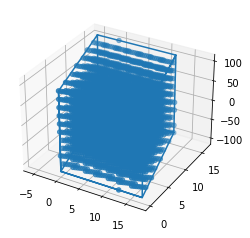

In [9]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import plotting_routines as plr
%matplotlib inline

fig1 = plt.figure()
plr.plot_3d_pts_box(fig1, threeD_pts1, sim_cell[:,0:3], sim_orig)
plt.show()